In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          20544     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5397 - acc: 0.1593
Epoch 00001: val_loss improved from inf to 1.94637, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_6_conv_checkpoint/001-1.9464.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.5397 - acc: 0.1594 - val_loss: 1.9464 - val_acc: 0.3951
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8601 - acc: 0.3884
Epoch 00002: val_loss improved from 1.94637 to 1.54764, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_6_conv_checkpoint/002-1.5476.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.8601 - acc: 0.3884 - val_loss: 1.5476 - val_acc: 0.5178
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6196 - acc: 0.4664
Epoch 00003: val_loss improved from 1.54764 to 1.40907, saving mode

36800/36805 [============================>.] - ETA: 0s - loss: 0.6392 - acc: 0.8088
Epoch 00023: val_loss improved from 0.57290 to 0.54757, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_6_conv_checkpoint/023-0.5476.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6392 - acc: 0.8089 - val_loss: 0.5476 - val_acc: 0.8467
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6282 - acc: 0.8111
Epoch 00024: val_loss did not improve from 0.54757
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6281 - acc: 0.8111 - val_loss: 0.5809 - val_acc: 0.8330
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6133 - acc: 0.8181
Epoch 00025: val_loss improved from 0.54757 to 0.54357, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_6_conv_checkpoint/025-0.5436.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6132 - acc: 0.8181 - val_loss: 0.5436 - val_acc

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4243 - acc: 0.8740
Epoch 00049: val_loss improved from 0.41787 to 0.40174, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_6_conv_checkpoint/049-0.4017.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4244 - acc: 0.8740 - val_loss: 0.4017 - val_acc: 0.8882
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4236 - acc: 0.8702
Epoch 00050: val_loss did not improve from 0.40174
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4235 - acc: 0.8702 - val_loss: 0.4098 - val_acc: 0.8894
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4130 - acc: 0.8746
Epoch 00051: val_loss improved from 0.40174 to 0.39408, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_6_conv_checkpoint/051-0.3941.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4130 - acc: 0.8746 - val_loss: 0.3

36800/36805 [============================>.] - ETA: 0s - loss: 0.3383 - acc: 0.8946
Epoch 00076: val_loss did not improve from 0.37369
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3383 - acc: 0.8946 - val_loss: 0.3786 - val_acc: 0.9017
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3293 - acc: 0.8984
Epoch 00077: val_loss improved from 0.37369 to 0.36265, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_6_conv_checkpoint/077-0.3626.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3293 - acc: 0.8984 - val_loss: 0.3626 - val_acc: 0.9054
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3275 - acc: 0.8998
Epoch 00078: val_loss did not improve from 0.36265
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3275 - acc: 0.8998 - val_loss: 0.3917 - val_acc: 0.8994
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3263 - acc

36800/36805 [============================>.] - ETA: 0s - loss: 0.2778 - acc: 0.9122
Epoch 00104: val_loss did not improve from 0.35206
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2778 - acc: 0.9122 - val_loss: 0.3665 - val_acc: 0.9054
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2750 - acc: 0.9142
Epoch 00105: val_loss did not improve from 0.35206
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2750 - acc: 0.9142 - val_loss: 0.3628 - val_acc: 0.9092
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2757 - acc: 0.9118
Epoch 00106: val_loss did not improve from 0.35206
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2756 - acc: 0.9118 - val_loss: 0.3599 - val_acc: 0.9099
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.9120
Epoch 00107: val_loss did not improve from 0.35206
36805/36805 [=====================

Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2409 - acc: 0.9218
Epoch 00133: val_loss did not improve from 0.34944
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2409 - acc: 0.9218 - val_loss: 0.3665 - val_acc: 0.9115
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2366 - acc: 0.9234
Epoch 00134: val_loss did not improve from 0.34944
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2366 - acc: 0.9234 - val_loss: 0.3582 - val_acc: 0.9126
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2392 - acc: 0.9229
Epoch 00135: val_loss did not improve from 0.34944
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2392 - acc: 0.9229 - val_loss: 0.3505 - val_acc: 0.9126
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2352 - acc: 0.9223
Epoch 00136: val_loss did not improve from 0.34944
36805/36805 [=======

Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2096 - acc: 0.9306
Epoch 00163: val_loss did not improve from 0.34944
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2096 - acc: 0.9306 - val_loss: 0.3720 - val_acc: 0.9106
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2094 - acc: 0.9315
Epoch 00164: val_loss did not improve from 0.34944
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2094 - acc: 0.9315 - val_loss: 0.3760 - val_acc: 0.9122
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2096 - acc: 0.9313
Epoch 00165: val_loss did not improve from 0.34944
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2096 - acc: 0.9313 - val_loss: 0.3547 - val_acc: 0.9157
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2130 - acc: 0.9299
Epoch 00166: val_loss did not improve from 0.34944
36805/36805 [=======

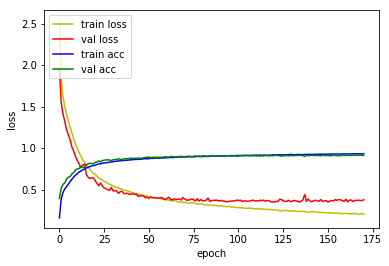

4815/4815 [==============================] - 3s 586us/sample - loss: 0.3966 - acc: 0.8897
Loss: 0.39662255904137284 Accuracy: 0.8897196

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6228 - acc: 0.1235
Epoch 00001: val_loss improved from inf to 2.30418, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_7_conv_checkpoint/001-2.3042.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.6226 - acc: 0.1236 - val_loss: 2.3042 - val_acc: 0.2474
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2138 - acc: 0.2615
Epoch 00002: val_loss improved from 2.30418 to 1.86820, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_7_conv_checkpoint/002-1.8682.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.2137 - acc: 0.2615 - val_loss: 1.8682 - val_acc: 0.4081
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.6224 - acc: 0.8092
Epoch 00023: val_loss improved from 0.46785 to 0.44159, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_7_conv_checkpoint/023-0.4416.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.6224 - acc: 0.8092 - val_loss: 0.4416 - val_acc: 0.8798
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6073 - acc: 0.8149
Epoch 00024: val_loss did not improve from 0.44159
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.6072 - acc: 0.8150 - val_loss: 0.4418 - val_acc: 0.8770
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6010 - acc: 0.8122
Epoch 00025: val_loss improved from 0.44159 to 0.42443, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_7_conv_checkpoint/025-0.4244.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.6010 - acc: 0.8122 - val_loss: 0.4244 - val_acc

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4207 - acc: 0.8716
Epoch 00049: val_loss did not improve from 0.31219
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4206 - acc: 0.8716 - val_loss: 0.3264 - val_acc: 0.9161
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4158 - acc: 0.8734
Epoch 00050: val_loss did not improve from 0.31219
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4157 - acc: 0.8734 - val_loss: 0.3191 - val_acc: 0.9119
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4141 - acc: 0.8698
Epoch 00051: val_loss improved from 0.31219 to 0.30113, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_7_conv_checkpoint/051-0.3011.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4141 - acc: 0.8698 - val_loss: 0.3011 - val_acc: 0.9154
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.3387 - acc: 0.8942
Epoch 00076: val_loss improved from 0.26009 to 0.25305, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_7_conv_checkpoint/076-0.2531.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3387 - acc: 0.8942 - val_loss: 0.2531 - val_acc: 0.9273
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3341 - acc: 0.8943
Epoch 00077: val_loss did not improve from 0.25305
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3341 - acc: 0.8943 - val_loss: 0.2670 - val_acc: 0.9280
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3376 - acc: 0.8945
Epoch 00078: val_loss did not improve from 0.25305
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3375 - acc: 0.8945 - val_loss: 0.2610 - val_acc: 0.9285
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3281 - acc

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2849 - acc: 0.9090
Epoch 00104: val_loss did not improve from 0.23397
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2849 - acc: 0.9090 - val_loss: 0.2358 - val_acc: 0.9357
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2858 - acc: 0.9082
Epoch 00105: val_loss did not improve from 0.23397
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2862 - acc: 0.9082 - val_loss: 0.2551 - val_acc: 0.9308
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2824 - acc: 0.9096
Epoch 00106: val_loss did not improve from 0.23397
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2824 - acc: 0.9096 - val_loss: 0.2467 - val_acc: 0.9327
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2788 - acc: 0.9105
Epoch 00107: val_loss did not improve from 0.23397
36805/36805 [=======

Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2491 - acc: 0.9203
Epoch 00133: val_loss did not improve from 0.22474
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2491 - acc: 0.9203 - val_loss: 0.2337 - val_acc: 0.9317
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2508 - acc: 0.9183
Epoch 00134: val_loss did not improve from 0.22474
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2508 - acc: 0.9183 - val_loss: 0.2365 - val_acc: 0.9404
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2442 - acc: 0.9206
Epoch 00135: val_loss did not improve from 0.22474
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2443 - acc: 0.9206 - val_loss: 0.2301 - val_acc: 0.9401
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2434 - acc: 0.9206
Epoch 00136: val_loss did not improve from 0.22474
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2200 - acc: 0.9262
Epoch 00161: val_loss did not improve from 0.21406
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2200 - acc: 0.9262 - val_loss: 0.2217 - val_acc: 0.9392
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2191 - acc: 0.9285
Epoch 00162: val_loss did not improve from 0.21406
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2191 - acc: 0.9284 - val_loss: 0.2332 - val_acc: 0.9411
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2186 - acc: 0.9280
Epoch 00163: val_loss did not improve from 0.21406
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2186 - acc: 0.9280 - val_loss: 0.2351 - val_acc: 0.9418
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2119 - acc: 0.9300
Epoch 00164: val_loss did not improve from 0.21406
36805/36805 [=====================

Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1950 - acc: 0.9365
Epoch 00191: val_loss did not improve from 0.21406
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1950 - acc: 0.9365 - val_loss: 0.2266 - val_acc: 0.9413
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1942 - acc: 0.9354
Epoch 00192: val_loss did not improve from 0.21406
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1942 - acc: 0.9354 - val_loss: 0.2261 - val_acc: 0.9448
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1914 - acc: 0.9352
Epoch 00193: val_loss did not improve from 0.21406
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1914 - acc: 0.9351 - val_loss: 0.2348 - val_acc: 0.9413
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1972 - acc: 0.9346
Epoch 00194: val_loss did not improve from 0.21406
36805/36805 [=======

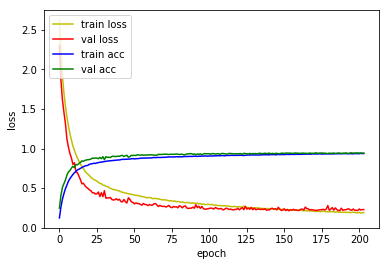

4815/4815 [==============================] - 3s 546us/sample - loss: 0.2571 - acc: 0.9259
Loss: 0.2571429381241803 Accuracy: 0.9258567

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6241 - acc: 0.1349
Epoch 00001: val_loss improved from inf to 2.23738, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/001-2.2374.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.6241 - acc: 0.1349 - val_loss: 2.2374 - val_acc: 0.3100
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0989 - acc: 0.3208
Epoch 00002: val_loss improved from 2.23738 to 1.60699, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/002-1.6070.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.0988 - acc: 0.3208 - val_loss: 1.6070 - val_acc: 0.5295
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5827 - acc: 0.8162
Epoch 00023: val_loss improved from 0.36244 to 0.35189, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/023-0.3519.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5826 - acc: 0.8162 - val_loss: 0.3519 - val_acc: 0.9054
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5674 - acc: 0.8207
Epoch 00024: val_loss improved from 0.35189 to 0.32842, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/024-0.3284.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5673 - acc: 0.8207 - val_loss: 0.3284 - val_acc: 0.9078
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5534 - acc: 0.8256
Epoch 00025: val_loss improved from 0.32842 to 0.32526, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/025-0.3253.hdf5
36805/368

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3718 - acc: 0.8833
Epoch 00048: val_loss improved from 0.22505 to 0.21515, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/048-0.2151.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3717 - acc: 0.8833 - val_loss: 0.2151 - val_acc: 0.9394
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3549 - acc: 0.8862
Epoch 00049: val_loss did not improve from 0.21515
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3550 - acc: 0.8862 - val_loss: 0.2236 - val_acc: 0.9385
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3594 - acc: 0.8873
Epoch 00050: val_loss did not improve from 0.21515
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3593 - acc: 0.8874 - val_loss: 0.2190 - val_acc: 0.9392
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2771 - acc: 0.9122
Epoch 00074: val_loss did not improve from 0.18167
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2771 - acc: 0.9122 - val_loss: 0.1829 - val_acc: 0.9525
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2739 - acc: 0.9130
Epoch 00075: val_loss improved from 0.18167 to 0.18130, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/075-0.1813.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2739 - acc: 0.9130 - val_loss: 0.1813 - val_acc: 0.9495
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2725 - acc: 0.9151
Epoch 00076: val_loss did not improve from 0.18130
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2725 - acc: 0.9151 - val_loss: 0.1826 - val_acc: 0.9502
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.2295 - acc: 0.9252
Epoch 00101: val_loss did not improve from 0.16572
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2295 - acc: 0.9252 - val_loss: 0.1772 - val_acc: 0.9571
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2202 - acc: 0.9277
Epoch 00102: val_loss did not improve from 0.16572
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2202 - acc: 0.9278 - val_loss: 0.1703 - val_acc: 0.9548
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2233 - acc: 0.9289
Epoch 00103: val_loss did not improve from 0.16572
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2233 - acc: 0.9289 - val_loss: 0.1744 - val_acc: 0.9546
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2192 - acc: 0.9293
Epoch 00104: val_loss did not improve from 0.16572
36805/36805 [=====================

Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1815 - acc: 0.9408
Epoch 00130: val_loss did not improve from 0.15778
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1815 - acc: 0.9408 - val_loss: 0.1748 - val_acc: 0.9534
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1881 - acc: 0.9385
Epoch 00131: val_loss did not improve from 0.15778
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1880 - acc: 0.9385 - val_loss: 0.1621 - val_acc: 0.9595
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1858 - acc: 0.9397
Epoch 00132: val_loss did not improve from 0.15778
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1857 - acc: 0.9397 - val_loss: 0.1650 - val_acc: 0.9590
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9393
Epoch 00133: val_loss did not improve from 0.15778
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.1601 - acc: 0.9472
Epoch 00158: val_loss improved from 0.15306 to 0.15264, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_8_conv_checkpoint/158-0.1526.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1601 - acc: 0.9472 - val_loss: 0.1526 - val_acc: 0.9613
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1570 - acc: 0.9484
Epoch 00159: val_loss did not improve from 0.15264
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1569 - acc: 0.9484 - val_loss: 0.1529 - val_acc: 0.9618
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1589 - acc: 0.9459
Epoch 00160: val_loss did not improve from 0.15264
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1588 - acc: 0.9459 - val_loss: 0.1631 - val_acc: 0.9599
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1582 - 

Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1392 - acc: 0.9539
Epoch 00187: val_loss did not improve from 0.14983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1392 - acc: 0.9539 - val_loss: 0.1640 - val_acc: 0.9616
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1389 - acc: 0.9535
Epoch 00188: val_loss did not improve from 0.14983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1389 - acc: 0.9535 - val_loss: 0.1607 - val_acc: 0.9571
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1359 - acc: 0.9544
Epoch 00189: val_loss did not improve from 0.14983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1359 - acc: 0.9544 - val_loss: 0.1824 - val_acc: 0.9560
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1420 - acc: 0.9522
Epoch 00190: val_loss did not improve from 0.14983
36805/36805 [=======

Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9596
Epoch 00217: val_loss did not improve from 0.14983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1205 - acc: 0.9596 - val_loss: 0.1617 - val_acc: 0.9644
Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.9591
Epoch 00218: val_loss did not improve from 0.14983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1202 - acc: 0.9591 - val_loss: 0.1616 - val_acc: 0.9588
Epoch 219/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1231 - acc: 0.9595
Epoch 00219: val_loss did not improve from 0.14983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1231 - acc: 0.9595 - val_loss: 0.1807 - val_acc: 0.9595
Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9590
Epoch 00220: val_loss did not improve from 0.14983
36805/36805 [=======

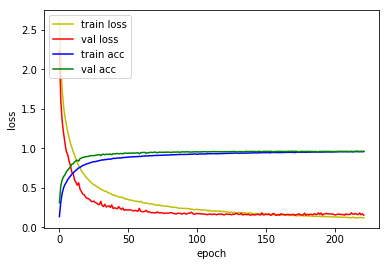

4815/4815 [==============================] - 3s 578us/sample - loss: 0.1983 - acc: 0.9464
Loss: 0.1982507915310523 Accuracy: 0.94641745

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6389 - acc: 0.1340
Epoch 00001: val_loss improved from inf to 2.23269, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/001-2.2327.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.6389 - acc: 0.1341 - val_loss: 2.2327 - val_acc: 0.3394
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2451 - acc: 0.2758
Epoch 00002: val_loss improved from 2.23269 to 1.84421, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/002-1.8442.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.2451 - acc: 0.2757 - val_loss: 1.8442 - val_acc: 0.4799
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8463 - acc: 0.7201
Epoch 00023: val_loss improved from 0.48291 to 0.46827, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/023-0.4683.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.8463 - acc: 0.7201 - val_loss: 0.4683 - val_acc: 0.8577
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8329 - acc: 0.7255
Epoch 00024: val_loss did not improve from 0.46827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.8329 - acc: 0.7256 - val_loss: 0.4787 - val_acc: 0.8572
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8168 - acc: 0.7313
Epoch 00025: val_loss did not improve from 0.46827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.8169 - acc: 0.7313 - val_loss: 0.5138 - val_acc: 0.8479
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5672 - acc: 0.8162
Epoch 00048: val_loss did not improve from 0.29691
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5673 - acc: 0.8162 - val_loss: 0.2973 - val_acc: 0.9113
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5649 - acc: 0.8142
Epoch 00049: val_loss improved from 0.29691 to 0.27235, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/049-0.2723.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5649 - acc: 0.8142 - val_loss: 0.2723 - val_acc: 0.9206
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5598 - acc: 0.8152
Epoch 00050: val_loss did not improve from 0.27235
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5598 - acc: 0.8153 - val_loss: 0.2792 - val_acc: 0.9192
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.4561 - acc: 0.8482
Epoch 00075: val_loss improved from 0.23036 to 0.22823, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/075-0.2282.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4560 - acc: 0.8482 - val_loss: 0.2282 - val_acc: 0.9385
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4488 - acc: 0.8531
Epoch 00076: val_loss did not improve from 0.22823
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4488 - acc: 0.8531 - val_loss: 0.2335 - val_acc: 0.9320
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4412 - acc: 0.8545
Epoch 00077: val_loss improved from 0.22823 to 0.21951, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/077-0.2195.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4413 - acc: 0.8544 - val_loss: 0.2195 - val_acc

Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3636 - acc: 0.8785
Epoch 00103: val_loss did not improve from 0.20328
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3635 - acc: 0.8785 - val_loss: 0.2231 - val_acc: 0.9352
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3625 - acc: 0.8775
Epoch 00104: val_loss did not improve from 0.20328
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3625 - acc: 0.8775 - val_loss: 0.2139 - val_acc: 0.9406
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3535 - acc: 0.8801
Epoch 00105: val_loss did not improve from 0.20328
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3535 - acc: 0.8801 - val_loss: 0.2271 - val_acc: 0.9406
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3641 - acc: 0.8802
Epoch 00106: val_loss did not improve from 0.20328
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.3066 - acc: 0.8959
Epoch 00132: val_loss did not improve from 0.20270
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3066 - acc: 0.8959 - val_loss: 0.2075 - val_acc: 0.9394
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3082 - acc: 0.8948
Epoch 00133: val_loss improved from 0.20270 to 0.20264, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/133-0.2026.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3082 - acc: 0.8948 - val_loss: 0.2026 - val_acc: 0.9415
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3133 - acc: 0.8932
Epoch 00134: val_loss improved from 0.20264 to 0.20232, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_9_conv_checkpoint/134-0.2023.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3132 - acc: 0.8932 - val_loss: 0.2023 - val_a

36800/36805 [============================>.] - ETA: 0s - loss: 0.2692 - acc: 0.9057
Epoch 00160: val_loss did not improve from 0.19827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2691 - acc: 0.9057 - val_loss: 0.2109 - val_acc: 0.9450
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2641 - acc: 0.9079
Epoch 00161: val_loss did not improve from 0.19827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2640 - acc: 0.9079 - val_loss: 0.2197 - val_acc: 0.9411
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2604 - acc: 0.9103
Epoch 00162: val_loss did not improve from 0.19827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2603 - acc: 0.9103 - val_loss: 0.2188 - val_acc: 0.9443
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2597 - acc: 0.9108
Epoch 00163: val_loss did not improve from 0.19827
36805/36805 [=====================

Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2374 - acc: 0.9181
Epoch 00190: val_loss did not improve from 0.19827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2373 - acc: 0.9181 - val_loss: 0.2149 - val_acc: 0.9497
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2352 - acc: 0.9194
Epoch 00191: val_loss did not improve from 0.19827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2352 - acc: 0.9194 - val_loss: 0.2269 - val_acc: 0.9450
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2340 - acc: 0.9186
Epoch 00192: val_loss did not improve from 0.19827
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2339 - acc: 0.9187 - val_loss: 0.2121 - val_acc: 0.9474
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2261 - acc: 0.9203
Epoch 00193: val_loss did not improve from 0.19827
36805/36805 [=======

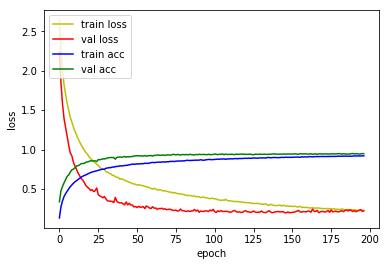

4815/4815 [==============================] - 3s 585us/sample - loss: 0.2737 - acc: 0.9238
Loss: 0.2736799772716633 Accuracy: 0.92377985



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_ch_64_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_ch_64_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_64_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 64)          20544     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 5

4815/4815 [==============================] - 3s 625us/sample - loss: 0.2737 - acc: 0.9238
Loss: 0.2736799772716633 Accuracy: 0.92377985


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_64_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 64)          20544     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 5

4815/4815 [==============================] - 3s 654us/sample - loss: 0.2823 - acc: 0.9294
Loss: 0.2822953768701197 Accuracy: 0.92938733
